In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from scipy.signal import savgol_filter
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [11]:
# -- ECCO GRIDS -- 
# -- FOR PLOTTING -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

In [2]:
# -- GOM tide gauges -- 
tg_data = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges_2008_2017.mat')
t_rec = []; 
for i in range(len(tg_data['t_grid'][0,:])):
    t_i = datetime.fromordinal(tg_data['t_grid'][0,i] - 366)
    t_rec.append(t_i)
data_da = xr.DataArray(data=tg_data['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data['ID'][0,:]), time=(["time"], t_rec),
                            lon=(['location'], tg_data['lon'][0,:]), lat=(['location'], tg_data['lat'][0,:]),
                        ),        
                       )
tg_data_l = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges_long.mat')
t_rec_l = []; 
for i in range(len(tg_data_l['t_grid'][0,:])):
    t_i_l = datetime.fromordinal(tg_data_l['t_grid'][0,i] - 366)
    t_rec_l.append(t_i_l)
data_da_l = xr.DataArray(data=tg_data_l['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data_l['ID'][0,:]), time=(["time"], t_rec_l),
                            lon=(['location'], tg_data_l['lon'][0,:]), lat=(['location'], tg_data_l['lat'][0,:]),
                        ),        
                       )
id_tags = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE STATE DOCKS', 'BAY WAVELAND' ,'SHELL BEACH', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON II PIER', \
          'USCG FREEPORT', 'CORPUS CHRISTI', 'PORT ISBEL']

In [22]:
# --- tide gauge --- 
# - only over a specific decade 
t_s = '2010-01-15'
t_e = '2019-12-15'
tg_sub = data_da_l.sel(time=slice(t_s, t_e))
tg_sub_a = tg_sub - data_da_l.sel(time=slice(t_s, t_e)).mean(dim='time')
p1_test = tg_sub.polyfit(dim='time', deg=1)
p1_test = (p1_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365
# - total tide gauge record 
# - subset to remove mean from all years 
t_s = '1993-01-15'
t_e = '2021-06-30'
tg_sub_l = data_da_l.sel(time=slice(t_s, t_e))
tg_sub_l_a = tg_sub_l - data_da_l.sel(time=slice(t_s, t_e)).mean(dim='time')

In [23]:
# -- Vertical Land Motion -- from multiple stations interpolated to tide gauge sites (better data)
file_int = open("/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/vlm_at_psmsl_gauges.txt")
data_int = file_int.readlines()
file_int.close()
name = []
name_row = []
for i in range(len(data_int)):
    if data_int[i][0] == '>':
        for j in range(len(data_int[i])):
            if data_int[i][j] == '\n':
                ee = j
                break
        name.append(data_int[i][9:ee])
        name_row.append(i)

In [24]:
# -- processing to get one number per tide gauge site 
id_tags = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY, ST.ANDREWS BAY, FL', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE STATE DOCKS, ALABAMA', 'BAY WAVELAND YACHT CLUB' ,'SHELL BEACH, LOUISIANA', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON II, PIER 21, TX', \
          'FREEPORT', 'CORPUS CHRISTI, GULF MEXICO, TX', 'PORT ISABEL']
vlm_rate = np.nan*np.ones(len(id_tags))
vlm_un = np.nan*np.ones(len(id_tags))
for i in range(len(id_tags)):
    ii = name.index(id_tags[i])
    this_row = data_int[name_row[ii]+1].split()
    vlm_rate[i] = -1*np.float64(this_row[3])/1000  # convert from mm/yr
    vlm_un[i] = np.float64(this_row[4])/1000 # uncertainty 

In [25]:
# -- compare values 
tg_obp_trend_a = p1_test # - np.nanmean(p1_test)
print('tide gauge trend')
print(tg_obp_trend_a.data)
# print('percent of tide gauge trend from VLM')
# print(100*(rate/tg_obp_trend_a.data))
print('percent of tide gauge trend from VLM sta. interp')
print(100*(vlm_rate/tg_obp_trend_a.data))
tg_obp_trend_a = p1_test.data
tg_obp_trend_a_mvlm = p1_test.data - vlm_rate
print('VLM corrected tide gauge trend')
print(tg_obp_trend_a_mvlm)

tide gauge trend
[0.01108719 0.01315545 0.01043598 0.01068213 0.01316909 0.01450221
 0.01403922 0.01399037 0.01641781 0.01669808 0.01323759 0.01548445
 0.01643348 0.01708368 0.02398381 0.02325881 0.01843789 0.01764871
 0.01569731]
percent of tide gauge trend from VLM sta. interp
[13.30364071 11.40971633 13.76008393 14.03277805 11.38271944  4.08903327
  7.57876971 12.7230361  13.65589978 12.83979886 15.72794187  6.36122082
  7.69161647 40.5182104  11.37017211 14.30425782 17.67013856  9.93273564
 11.1675208 ]
VLM corrected tide gauge trend
[0.00961219 0.01165445 0.00899998 0.00918313 0.01167009 0.01390921
 0.01297522 0.01221037 0.01417581 0.01455408 0.01115559 0.01449945
 0.01516948 0.01016168 0.02125681 0.01993181 0.01517989 0.01589571
 0.01394431]


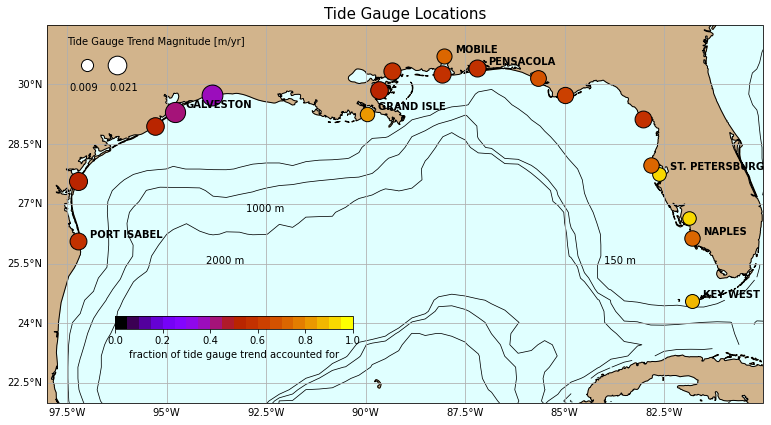

In [51]:
# Locations 
# TAKE FROM SEPARATE ESTIMATES 
argo = 0.00472 # OLD = 0.00742
argo_grace = argo + 0.00355 
cmap = mpl.cm.get_cmap('gnuplot',20)
clow = 0; chigh = 1; norm = mpl.colors.Normalize(vmin=clow, vmax=chigh)

id_tags_short = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY, ST.ANDREWS BAY, FL', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE', 'BAY WAVELAND YACHT CLUB' ,'SHELL BEACH, LOUISIANA', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON', \
          'FREEPORT', 'CORPUS CHRISTI, GULF MEXICO, TX', 'PORT ISABEL']

f, ax = plt.subplots(1,1,figsize=(11,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
for i in range(len(tg_data['lat'][0,:])):
    s_i = 250*(tg_obp_trend_a[i] - vlm_rate[i])/(np.nanmax(tg_obp_trend_a - vlm_rate) - np.nanmin(tg_obp_trend_a - vlm_rate))
    ax.scatter(tg_data['lon'][0,i],tg_data['lat'][0,i], \
               color=cmap(argo_grace/(tg_obp_trend_a[i] - vlm_rate[i])),\
               s=s_i,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')

ax.scatter(-97,30.5,200*np.nanmin(tg_obp_trend_a - vlm_rate)/(np.nanmax(tg_obp_trend_a - vlm_rate) - np.nanmin(tg_obp_trend_a - vlm_rate)),\
           color='w',transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
ax.text(-97.45,29.85,str(np.round(np.nanmin(tg_obp_trend_a - vlm_rate),3)))
ax.scatter(-96.25,30.5,200*np.nanmax(tg_obp_trend_a - vlm_rate)/(np.nanmax(tg_obp_trend_a - vlm_rate) - np.nanmin(tg_obp_trend_a - vlm_rate)),\
           color='w',transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
ax.text(-96.45,29.85,str(np.round(np.nanmax(tg_obp_trend_a - vlm_rate),3)))
ax.text(-97.5,31,'Tide Gauge Trend Magnitude [m/yr]')
    
i0 = 1
i1 = 3
i2 = 10
i3 = 13
i4 = 18
ii = [0,1,3,8,10,13,15,18]
for i in ii:
    ax.text(tg_data['lon'][0,i]+0.28,tg_data['lat'][0,i]+0.1,id_tags_short[i],fontsize=10,fontweight='bold')

ax.contour(lons,lats,dep,levels=[150],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-84,25.5,'150 m', color='k')
ax.contour(lons,lats,dep,levels=[1000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-93,26.8,'1000 m', color='k')
ax.contour(lons,lats,dep,levels=[2000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-94,25.5,'2000 m', color='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_xlim([-98,-80]); ax.set_ylim([22,31.5]);
ax.set_title('Tide Gauge Locations',fontsize=15) 

ax.set_facecolor('#E0FFFF');
cbpos = [0.15, 0.23, 0.3, 0.03]; cax = f.add_axes(cbpos); 
f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label='fraction of tide gauge trend accounted for')
plt.tight_layout()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/tide_gauge_stations.jpg', dpi=250)

In [31]:
# -- LOAD LOTS OF AVISO for comp at tide gauges (MERGE larger datasets for a zoomed out view) 
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1993_1998.nc'
av1 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1999_2004.nc'
av2 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2005_2010.nc'
av3 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2011_2016.nc'
av4 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2017_2021.nc'
av5 = xr.open_dataset(av_path)
av_tot = xr.concat([av1,av2,av3,av4,av5], dim='time')

In [32]:
# AVISO temporal anomaly 
avsla_raw = av_tot.sla
avsla_raw_tot = avsla_raw.sel(time=slice("1993-01-01", "2021-08-02"))
avsla_raw_tot_mean = avsla_raw_tot.mean(dim='time')
avsla_raw_tot_a = avsla_raw_tot - avsla_raw_tot_mean

In [46]:
# interpolate to tide gauge locations 
avsla_raw_tot_a_sub_ar = avsla_raw_tot_a.sel(time=slice("2010-01-01", "2019-12-31"))
pavsla_star_ar = avsla_raw_tot_a_sub_ar.polyfit(dim='time', deg=1)  
# find AVISO nearest to tide gauge
nb_trend = np.nan*np.ones(len(data_da.lon))
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    avlonii = np.where((av_tot.longitude > sta_lon-.25) & (av_tot.longitude < sta_lon+.25))[0]
    avlatii = np.where((av_tot.latitude > sta_lat-.25) & (av_tot.latitude < sta_lat+.25))[0]
    coef = np.nanmean(pavsla_star_ar.polyfit_coefficients.data[0, avlatii][:,avlonii])
    nb_trend[i] = np.round(coef*1e9*60*60*24*365,5)

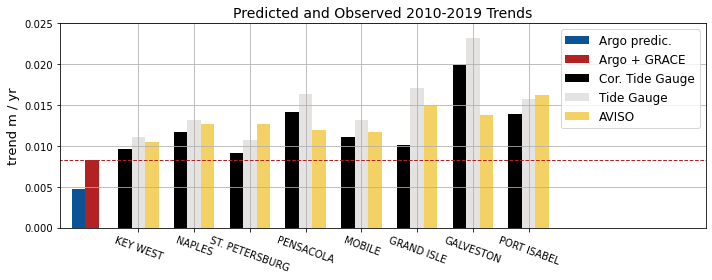

In [52]:
f, ax = plt.subplots(1,1,figsize=(10,4),tight_layout=True); ax.grid()
wid = 0.145

ax.bar(0.5, argo, width=wid,label='Argo predic.',color='#0b5394')
ax.bar(0.5+wid, argo_grace, width=wid,label='Argo + GRACE',color='#B22222')

wid = 0.145
ii = [0,1,3,8,10,13,15,18]
ipos = np.array([1,1.6,2.2,2.8,3.4,4,4.6,5.2])
for i in range(len(ii)):
    if i < 1:
        ax.bar(i+1,tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],width=wid,label='Cor. Tide Gauge',color='k') # #4a4a4a')
        # ax.errorbar(i+1,tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],yerr=vlm_un[ii[i]],capsize=3, color='r')
        ax.bar(i+1+wid,tg_obp_trend_a[ii[i]],width=wid,label='Tide Gauge', color='#e5e2e2')
        ax.bar(i+1+2*wid,nb_trend[ii[i]],width=wid, label='AVISO', color='#f1c232',alpha=0.75)
    else:
        ax.bar((ipos[i]),tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],width=wid,color='k') # '#4a4a4a')
        # ax.errorbar((ipos[i]),tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],yerr=vlm_un[ii[i]],capsize=3,color='r')
        ax.bar((ipos[i]) + wid,tg_obp_trend_a[ii[i]],width=wid,color='#e5e2e2')
        ax.bar((ipos[i]) + 2*wid,nb_trend[ii[i]],width=wid,color='#f1c232',alpha=0.75)

ax.plot([0,8],[argo_grace,argo_grace],color='#B22222',linestyle='--',linewidth=1)
ax.set_xlim([.3,7.25]); ax.set_xticks(ipos+wid); 
ax.set_xticklabels([id_tags_short[ii[0]],id_tags_short[ii[1]],id_tags_short[ii[2]][0:18],\
                    id_tags_short[ii[3]],id_tags_short[ii[4]],id_tags_short[ii[5]],\
                    id_tags_short[ii[6]],id_tags_short[ii[7]]], rotation=-20)
ax.set_ylim([0,0.025])
ax.set_title('Predicted and Observed 2010-2019 Trends', fontsize=14); ax.set_ylabel('trend m / yr',fontsize=13); ax.legend(loc=0,fontsize=12); 
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/tide_gauge_bar_comp.jpg', dpi=250)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_07_07/synthesis_5stations.jpg', dpi=250)